---
# Setup
---

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/debi2023-group3/Transformer-based-solutions-for-the-long-term-time-series-forecasting.git

Cloning into 'Transformer-based-solutions-for-the-long-term-time-series-forecasting'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 213 (delta 89), reused 173 (delta 49), pack-reused 0
Receiving objects: 100% (213/213), 38.29 MiB | 22.58 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [3]:
import os
os.chdir('Transformer-based-solutions-for-the-long-term-time-series-forecasting')

In [4]:
import sys
if not 'Transformer-based-solutions-for-the-long-term-time-series-forecasting' in sys.path:
    sys.path += ['Transformer-based-solutions-for-the-long-term-time-series-forecasting']
    
sys.path

['/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/opt/conda/lib/python310.zip',
 '/opt/conda/lib/python3.10',
 '/opt/conda/lib/python3.10/lib-dynload',
 '',
 '/root/.local/lib/python3.10/site-packages',
 '/opt/conda/lib/python3.10/site-packages',
 '/src/bq-helper',
 'Transformer-based-solutions-for-the-long-term-time-series-forecasting']

In [5]:
import torch
import pandas as pd
import numpy as np 

%matplotlib inline

from exp.exp_FEDformer import Exp_FEDFormer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import random
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [7]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    

"""
    **dotdict function**
    This function is used to convert a dictionary into
    an object whose keys can be accessed as attributes
"""
args = dotdict()

---
# Working on ETTh1 Dataset
---

In [8]:

args.model = 'FEDformer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.train_only = True
args.use_multi_gpu = False
args.use_gpu = True if torch.cuda.is_available() else False
args.learning_rate = 0.005
args.pred_len = 96 # prediction sequence length
args.label_len = 48 # start token length of NLinear decoder
args.seq_len = 96 # input sequence length of NLinear encoder

# whether to use automatic mixed precision training
args.use_amp = False
args.output_attention = False # whether to output attention in ecoder
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.train_only=True
args.checkpoints = './Checkpoints/FEDFormer_checkpoints' # location of model checkpoints
args.patience = 3
args.train_epochs = 6

args.data = 'ETTh1'  # data
args.root_path = './Datasets/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h

# NLinear decoder input: concat[start token series(label_len), zero padding series(pred_len)]
args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.mix = True
args.padding = 0
args.freq = 'h'
args.batch_size = 32 
args.loss = 'mse'
args.lradj = 'type1'
args.num_workers = 0
args.des = 'exp'
args.gpu = 0
args.modes=32
args.moving_avg=[12]
args.embed_type == 1

False

In [9]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [10]:
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}_test'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_96_test:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


## Trail 1: FEDFormer, Dataset:ETTh1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [11]:
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [12]:
Exp = Exp_FEDFormer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8449
val 2785
test 2785
	iters:  100, epoch: 1 | loss: 60.0549202
	speed: 0.3998sec/iter | left time: 593.6932sec
	iters:  200, epoch: 1 | loss: 0.6274696
	speed: 0.2857sec/iter | left time: 395.6334sec
Epoch: 1 cost time: 87.07703018188477
Epoch: 1, Steps: 264 | Train Loss: 5.6606379 Vali Loss: 1.0267363 Test Loss: 0.6197785
>>> Validation loss decreased (inf --> 1.026736).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 0.5414073
	speed: 0.5491sec/iter | left time: 670.4462sec
	iters:  200, epoch: 2 | loss: 0.4820983
	speed: 0.2870sec/iter | left time: 321.6961sec
Epoch: 2 cost time: 75.92024636268616
Epoch: 2, Steps: 264 | Train Loss: 0.4642860 Vali Loss: 0.8611074 Test Loss: 0.4461089
>>> Validation loss decreased (1.026736 --> 0.861107).  Saving model ...
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 0.4502985
	speed: 0.5548sec/iter | left time: 530.9660sec
	iters:  200, epoch: 3 | loss: 0.3849725
	speed: 0.2

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2785
test shape: (2784, 96, 7) (2784, 96, 7)
mae:0.44975391030311584, mse:0.4276447296142578, rmse:0.6539455056190491, mape:10.71375846862793, mspe:43768.3359375


<Figure size 1500x500 with 0 Axes>

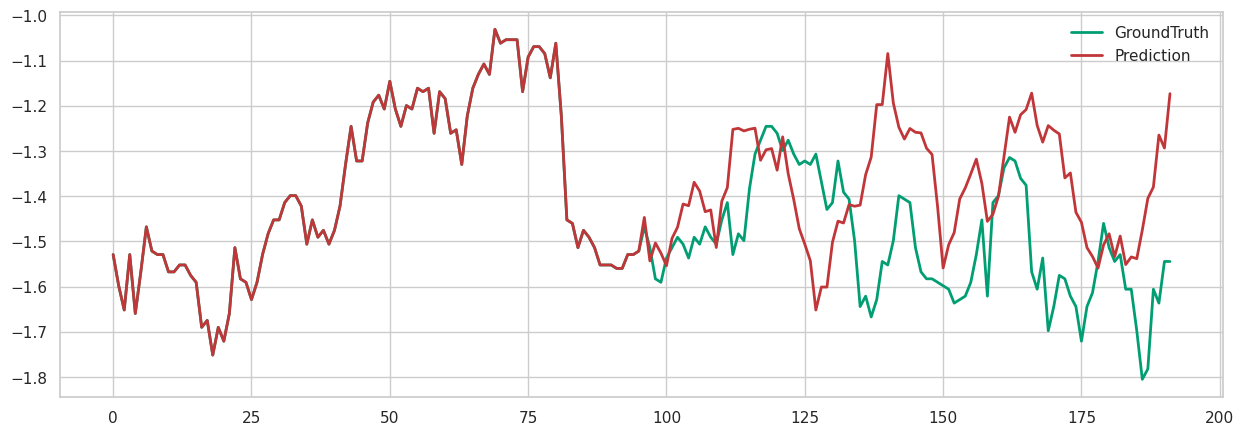

In [13]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTh1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [14]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [15]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8353
val 2689
test 2689
	iters:  100, epoch: 1 | loss: 0.4407395
	speed: 0.3495sec/iter | left time: 512.7014sec
	iters:  200, epoch: 1 | loss: 0.3806359
	speed: 0.3522sec/iter | left time: 481.4709sec
Epoch: 1 cost time: 91.91872644424438
Epoch: 1, Steps: 261 | Train Loss: 0.6851727 Vali Loss: 1.0932894 Test Loss: 0.4713536
>>> Validation loss decreased (inf --> 1.093289).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 14411.6640625
	speed: 0.6649sec/iter | left time: 801.9026sec
	iters:  200, epoch: 2 | loss: 158.7003784
	speed: 0.3523sec/iter | left time: 389.6402sec
Epoch: 2 cost time: 91.88660955429077
Epoch: 2, Steps: 261 | Train Loss: 57082.6310431 Vali Loss: 88.5265579 Test Loss: 93.1426010
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 116.3564453
	speed: 0.6643sec/iter | left time: 627.7288sec
	iters:  200, epoch: 3 | loss: 88.9726562
	speed: 0.3521sec/iter | left time: 

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2689
test shape: (2688, 192, 7) (2688, 192, 7)
mae:0.47621387243270874, mse:0.471353679895401, rmse:0.6865520477294922, mape:12.31765079498291, mspe:57530.35546875


<Figure size 1500x500 with 0 Axes>

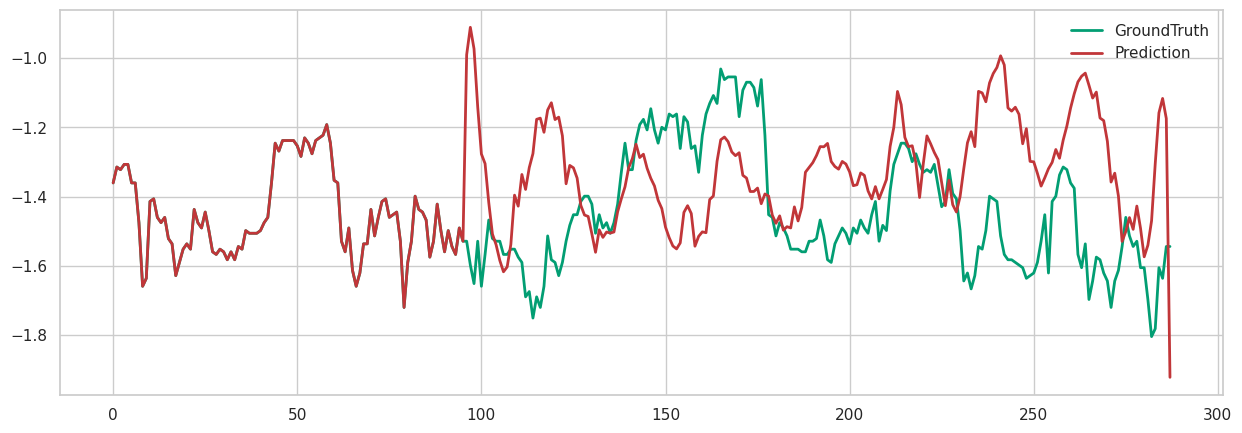

In [16]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTh1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [17]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [18]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2545
test 2545
	iters:  100, epoch: 1 | loss: 0.5541112
	speed: 0.4431sec/iter | left time: 636.6886sec
	iters:  200, epoch: 1 | loss: 9.7313471
	speed: 0.4470sec/iter | left time: 597.7021sec
Epoch: 1 cost time: 114.26112937927246
Epoch: 1, Steps: 256 | Train Loss: 164.1533104 Vali Loss: 2.2903104 Test Loss: 1.4870359
>>> Validation loss decreased (inf --> 2.290310).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 0.9096135
	speed: 0.8176sec/iter | left time: 965.5570sec
	iters:  200, epoch: 2 | loss: 0.7960415
	speed: 0.4465sec/iter | left time: 482.6501sec
Epoch: 2 cost time: 114.28392624855042
Epoch: 2, Steps: 256 | Train Loss: 0.9171509 Vali Loss: 1.6452051 Test Loss: 0.7424586
>>> Validation loss decreased (2.290310 --> 1.645205).  Saving model ...
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 0.7688172
	speed: 0.8182sec/iter | left time: 756.8315sec
	iters:  200, epoch: 3 | loss: 0.7648752
	speed: 

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2545
test shape: (2528, 336, 7) (2528, 336, 7)
mae:0.5609613060951233, mse:0.644935131072998, rmse:0.8030785322189331, mape:12.11585521697998, mspe:54703.82421875


<Figure size 1500x500 with 0 Axes>

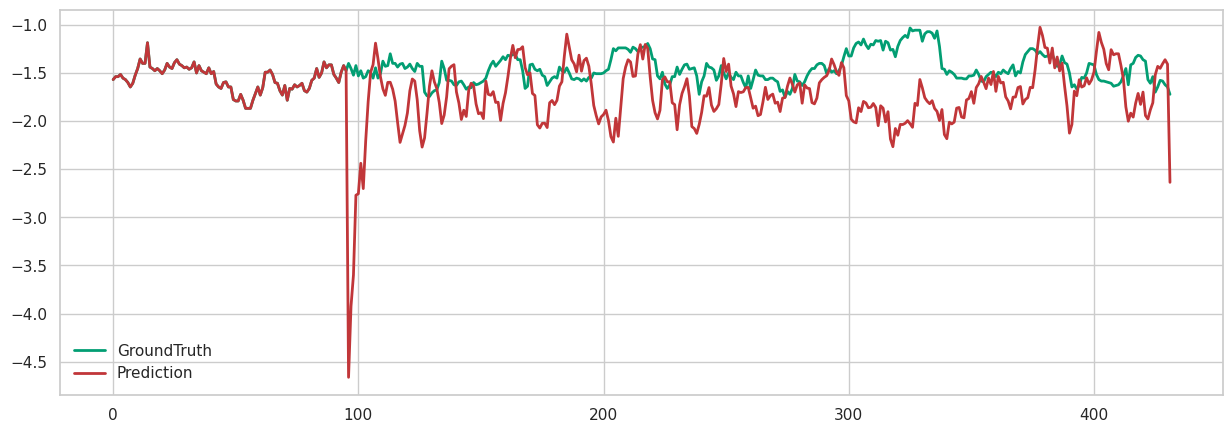

In [19]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTh1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [20]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [21]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7825
val 2161
test 2161
	iters:  100, epoch: 1 | loss: 0.6895569
	speed: 0.7021sec/iter | left time: 958.3728sec
	iters:  200, epoch: 1 | loss: 0.6352651
	speed: 0.7077sec/iter | left time: 895.2204sec
Epoch: 1 cost time: 172.6889500617981
Epoch: 1, Steps: 244 | Train Loss: 2.0348596 Vali Loss: 1.6534057 Test Loss: 0.5988027
>>> Validation loss decreased (inf --> 1.653406).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 0.6068862
	speed: 1.1882sec/iter | left time: 1331.9988sec
	iters:  200, epoch: 2 | loss: 2539.2902832
	speed: 0.7080sec/iter | left time: 722.8396sec
Epoch: 2 cost time: 172.7587480545044
Epoch: 2, Steps: 244 | Train Loss: 12330.6186523 Vali Loss: 151.5088196 Test Loss: 165.7052460
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 83.8179626
	speed: 1.1874sec/iter | left time: 1041.3859sec
	iters:  200, epoch: 3 | loss: 46.1898613
	speed: 0.7081sec/iter | left time: 

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2161
test shape: (2144, 720, 7) (2144, 720, 7)
mae:0.5638995170593262, mse:0.5988027453422546, rmse:0.7738234400749207, mape:12.513703346252441, mspe:55968.44140625


<Figure size 1500x500 with 0 Axes>

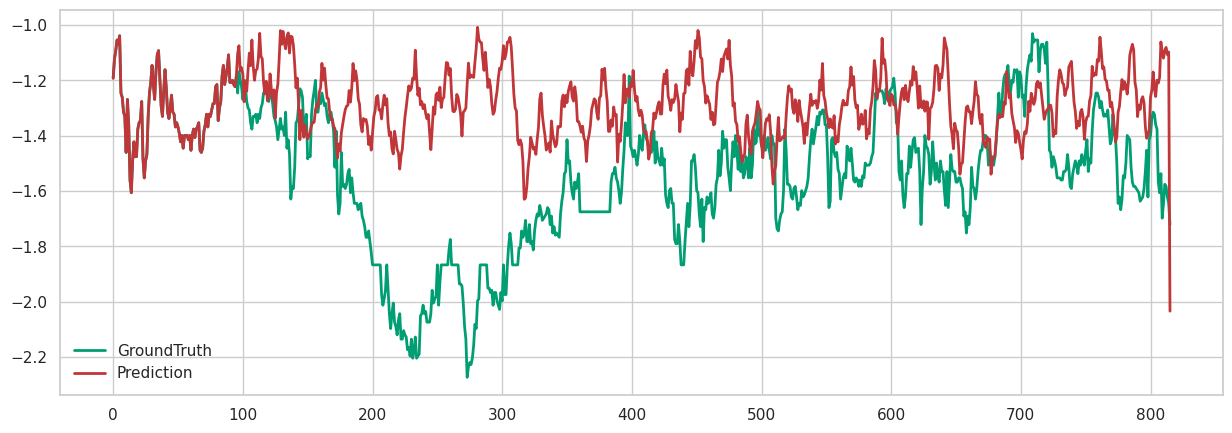

In [22]:
exp.test(setting)
torch.cuda.empty_cache()

---
# Working on ETTh2 Dataset
---

## Trail 1: FEDFormer, Dataset:ETTh2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [23]:
args.pred_len = 96
args.data = 'ETTh2'            # dataset name
args.data_path = 'ETTh2.csv'   # data file

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [24]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8449
val 2785
test 2785
	iters:  100, epoch: 1 | loss: 0.5810350
	speed: 0.2880sec/iter | left time: 427.7171sec
	iters:  200, epoch: 1 | loss: 14106.2500000
	speed: 0.2905sec/iter | left time: 402.2744sec
Epoch: 1 cost time: 76.6576817035675
Epoch: 1, Steps: 264 | Train Loss: 300.0575263 Vali Loss: 4.4884329 Test Loss: 5.6498842
>>> Validation loss decreased (inf --> 4.488433).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 1.7522488
	speed: 0.5583sec/iter | left time: 681.7243sec
	iters:  200, epoch: 2 | loss: 1.9483278
	speed: 0.2903sec/iter | left time: 325.3824sec
Epoch: 2 cost time: 76.57359647750854
Epoch: 2, Steps: 264 | Train Loss: 1.8017239 Vali Loss: 0.4973013 Test Loss: 0.7176393
>>> Validation loss decreased (4.488433 --> 0.497301).  Saving model ...
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 1.3316786
	speed: 0.5591sec/iter | left time: 535.0542sec
	iters:  200, epoch: 3 | loss: 1.0615938
	speed:

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2785
test shape: (2784, 96, 7) (2784, 96, 7)
mae:0.5058804750442505, mse:0.5291767716407776, rmse:0.7274453639984131, mape:2.8953018188476562, mspe:1083.035888671875


<Figure size 1500x500 with 0 Axes>

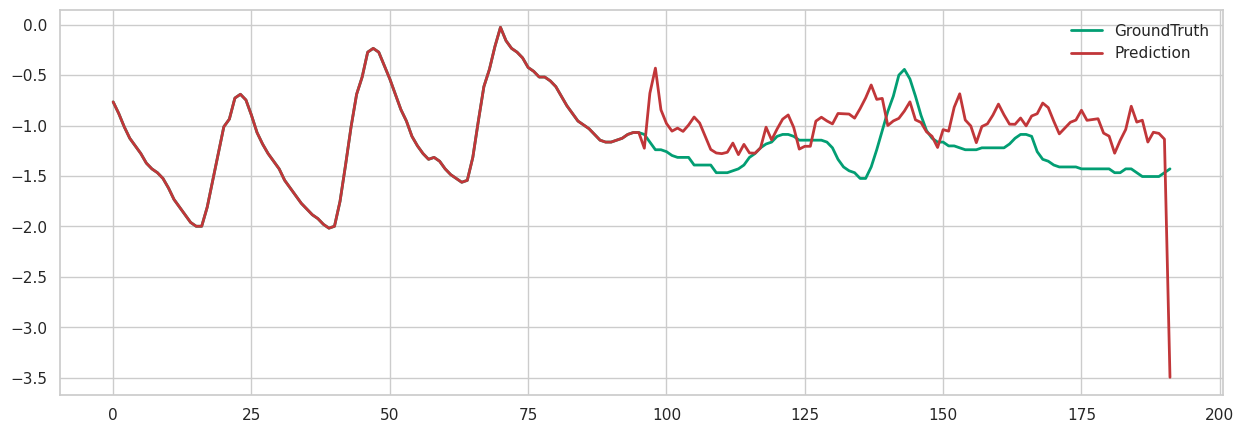

In [25]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTh2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [26]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [27]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8353
val 2689
test 2689
	iters:  100, epoch: 1 | loss: 0.6724851
	speed: 0.3493sec/iter | left time: 512.4504sec
	iters:  200, epoch: 1 | loss: 44.7478828
	speed: 0.3527sec/iter | left time: 482.1659sec
Epoch: 1 cost time: 91.89964628219604
Epoch: 1, Steps: 261 | Train Loss: 1126.1943586 Vali Loss: 2.1013997 Test Loss: 2.7024162
>>> Validation loss decreased (inf --> 2.101400).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 2.2744236
	speed: 0.6652sec/iter | left time: 802.1912sec
	iters:  200, epoch: 2 | loss: 2.3838079
	speed: 0.3522sec/iter | left time: 389.5683sec
Epoch: 2 cost time: 91.84422039985657
Epoch: 2, Steps: 261 | Train Loss: 2.7418843 Vali Loss: 0.7027351 Test Loss: 0.9189786
>>> Validation loss decreased (2.101400 --> 0.702735).  Saving model ...
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 1.2730932
	speed: 0.6654sec/iter | left time: 628.7815sec
	iters:  200, epoch: 3 | loss: 1.6867255
	speed: 

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2689
test shape: (2688, 192, 7) (2688, 192, 7)
mae:0.576029896736145, mse:0.6332398653030396, rmse:0.7957636713981628, mape:3.039389133453369, mspe:1123.1099853515625


<Figure size 1500x500 with 0 Axes>

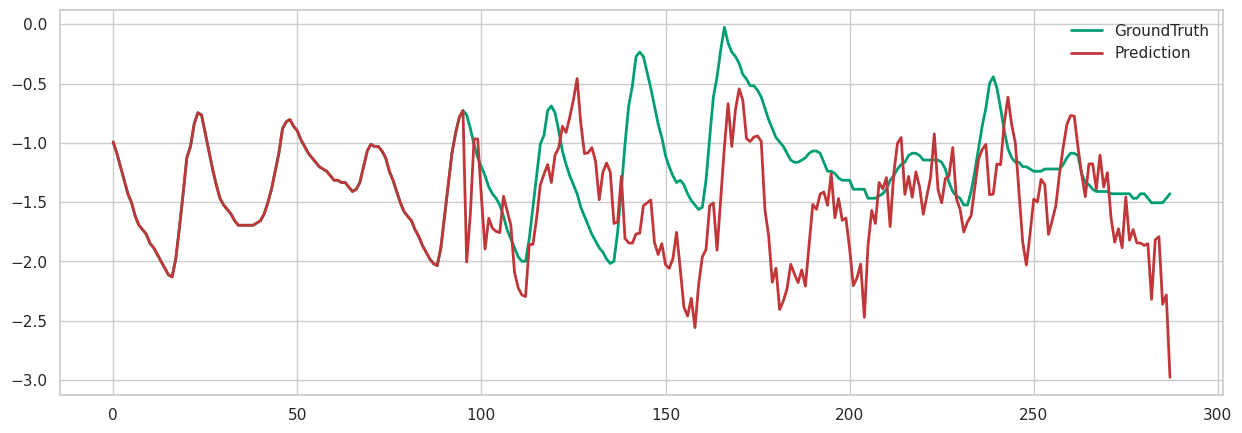

In [28]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTh2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [29]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [30]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2545
test 2545
	iters:  100, epoch: 1 | loss: 0.6545388
	speed: 0.4422sec/iter | left time: 635.4340sec
	iters:  200, epoch: 1 | loss: 0.7699514
	speed: 0.4468sec/iter | left time: 597.3318sec
Epoch: 1 cost time: 114.21189498901367
Epoch: 1, Steps: 256 | Train Loss: 1.0879725 Vali Loss: 0.4510478 Test Loss: 0.4867258
>>> Validation loss decreased (inf --> 0.451048).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 411.6275024
	speed: 0.8163sec/iter | left time: 964.0142sec
	iters:  200, epoch: 2 | loss: 23.7055855
	speed: 0.4469sec/iter | left time: 483.1008sec
Epoch: 2 cost time: 114.23458886146545
Epoch: 2, Steps: 256 | Train Loss: 8951.0230158 Vali Loss: 7.7504907 Test Loss: 11.0269175
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 16.1638966
	speed: 0.8158sec/iter | left time: 754.6065sec
	iters:  200, epoch: 3 | loss: 10.8108654
	speed: 0.4463sec/iter | left time: 368.

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2545
test shape: (2528, 336, 7) (2528, 336, 7)
mae:0.4875130355358124, mse:0.4867255985736847, rmse:0.6976572275161743, mape:2.1813838481903076, mspe:568.2166748046875


<Figure size 1500x500 with 0 Axes>

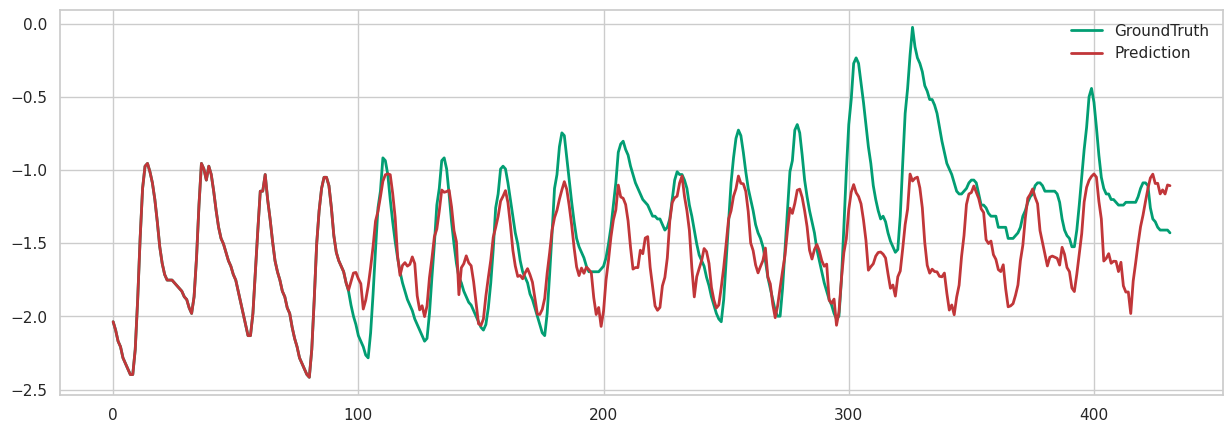

In [31]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTh2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [32]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [33]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7825
val 2161
test 2161
	iters:  100, epoch: 1 | loss: 1.0097110
	speed: 0.7031sec/iter | left time: 959.7794sec
	iters:  200, epoch: 1 | loss: 30362.7753906
	speed: 0.7084sec/iter | left time: 896.1793sec
Epoch: 1 cost time: 172.84682369232178
Epoch: 1, Steps: 244 | Train Loss: 912.3044146 Vali Loss: 17.6100044 Test Loss: 17.9710178
>>> Validation loss decreased (inf --> 17.610004).  Saving model ...
Updating learning rate to 0.005
	iters:  100, epoch: 2 | loss: 1.8902767
	speed: 1.1887sec/iter | left time: 1332.4989sec
	iters:  200, epoch: 2 | loss: 1.7791165
	speed: 0.7081sec/iter | left time: 722.9521sec
Epoch: 2 cost time: 172.79891228675842
Epoch: 2, Steps: 244 | Train Loss: 3.2631954 Vali Loss: 1.1696651 Test Loss: 1.0270125
>>> Validation loss decreased (17.610004 --> 1.169665).  Saving model ...
Updating learning rate to 0.0025
	iters:  100, epoch: 3 | loss: 1.1704307
	speed: 1.1885sec/iter | left time: 1042.3111sec
	iters:  200, epoch: 3 | loss: 1.324457

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2161
test shape: (2144, 720, 7) (2144, 720, 7)
mae:0.6148812770843506, mse:0.6765228509902954, rmse:0.8225100636482239, mape:3.5008153915405273, mspe:1370.16650390625


<Figure size 1500x500 with 0 Axes>

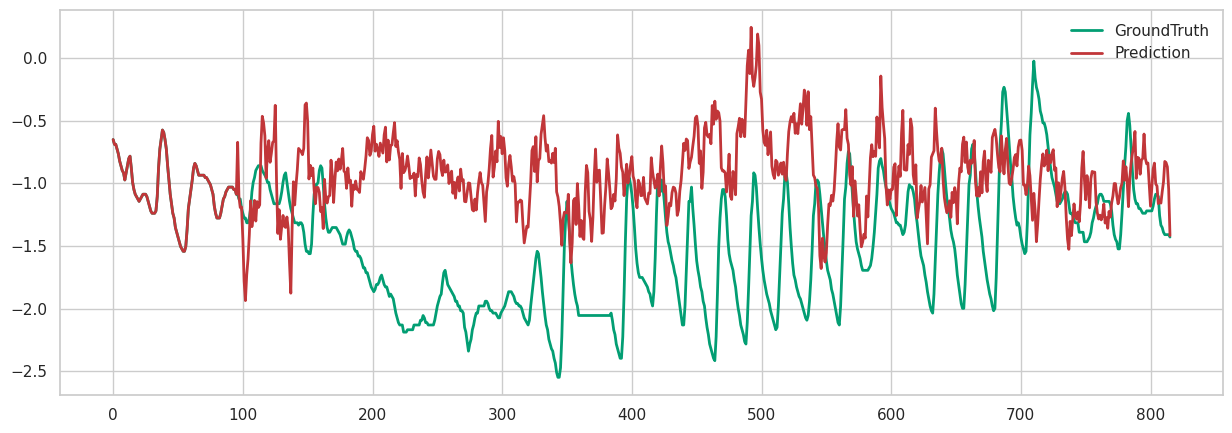

In [34]:
exp.test(setting)
torch.cuda.empty_cache()

---
# Working on ETTm1 Dataset
---

## Trail 1: FEDFormer, Dataset:ETTm1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [35]:
args.pred_len = 96
args.data = 'ETTm1'            # dataset name
args.data_path = 'ETTm1.csv'   # data file

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [36]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34369
val 11425
test 11425
	iters:  100, epoch: 1 | loss: 1.4677091
	speed: 0.2880sec/iter | left time: 1827.1282sec
	iters:  200, epoch: 1 | loss: 0.4250997
	speed: 0.2908sec/iter | left time: 1815.9236sec
	iters:  300, epoch: 1 | loss: 0.4303588
	speed: 0.2905sec/iter | left time: 1784.8566sec
	iters:  400, epoch: 1 | loss: 0.3361497
	speed: 0.2903sec/iter | left time: 1755.1173sec
	iters:  500, epoch: 1 | loss: 0.3236978
	speed: 0.2902sec/iter | left time: 1724.9638sec
	iters:  600, epoch: 1 | loss: 0.2276193
	speed: 0.2907sec/iter | left time: 1698.8951sec
	iters:  700, epoch: 1 | loss: 6830255.5000000
	speed: 0.2901sec/iter | left time: 1666.4745sec
	iters:  800, epoch: 1 | loss: 3149.0275879
	speed: 0.2895sec/iter | left time: 1634.1981sec
	iters:  900, epoch: 1 | loss: 1633.7319336
	speed: 0.2898sec/iter | left time: 1606.7302sec
	iters: 1000, epoch: 1 | loss: 2800.6506348
	speed: 0.2896sec/iter | left time: 1576.8827sec
Epoch: 1 cost time: 311.571918725967

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11425
test shape: (11424, 96, 7) (11424, 96, 7)
mae:2.8754100799560547, mse:42.463043212890625, rmse:6.516367435455322, mape:20.55994415283203, mspe:83946.5546875


<Figure size 1500x500 with 0 Axes>

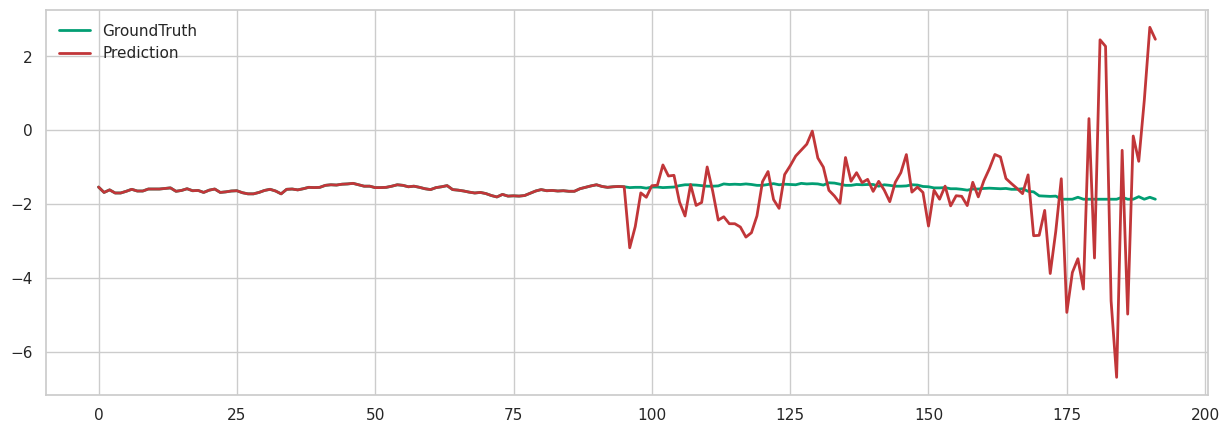

In [37]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTm1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [38]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [39]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34273
val 11329
test 11329
	iters:  100, epoch: 1 | loss: 2.0196919
	speed: 0.3491sec/iter | left time: 2208.6247sec
	iters:  200, epoch: 1 | loss: 44.6315346
	speed: 0.3523sec/iter | left time: 2194.0778sec
	iters:  300, epoch: 1 | loss: 1.9717484
	speed: 0.3517sec/iter | left time: 2155.0141sec
	iters:  400, epoch: 1 | loss: 1.3958369
	speed: 0.3521sec/iter | left time: 2121.8418sec
	iters:  500, epoch: 1 | loss: 1.0899613
	speed: 0.3517sec/iter | left time: 2084.2688sec
	iters:  600, epoch: 1 | loss: 0.8997592
	speed: 0.3516sec/iter | left time: 2048.7398sec
	iters:  700, epoch: 1 | loss: 0.7967808
	speed: 0.3520sec/iter | left time: 2015.6581sec
	iters:  800, epoch: 1 | loss: 0.8909024
	speed: 0.3516sec/iter | left time: 1978.5541sec
	iters:  900, epoch: 1 | loss: 0.7973886
	speed: 0.3521sec/iter | left time: 1945.8877sec
	iters: 1000, epoch: 1 | loss: 0.9725723
	speed: 0.3528sec/iter | left time: 1914.3907sec
Epoch: 1 cost time: 376.9073266983032
Epoch: 1, St

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11329
test shape: (11328, 192, 7) (11328, 192, 7)
mae:0.49690237641334534, mse:0.5375031232833862, rmse:0.733146071434021, mape:2.7395873069763184, mspe:368.99200439453125


<Figure size 1500x500 with 0 Axes>

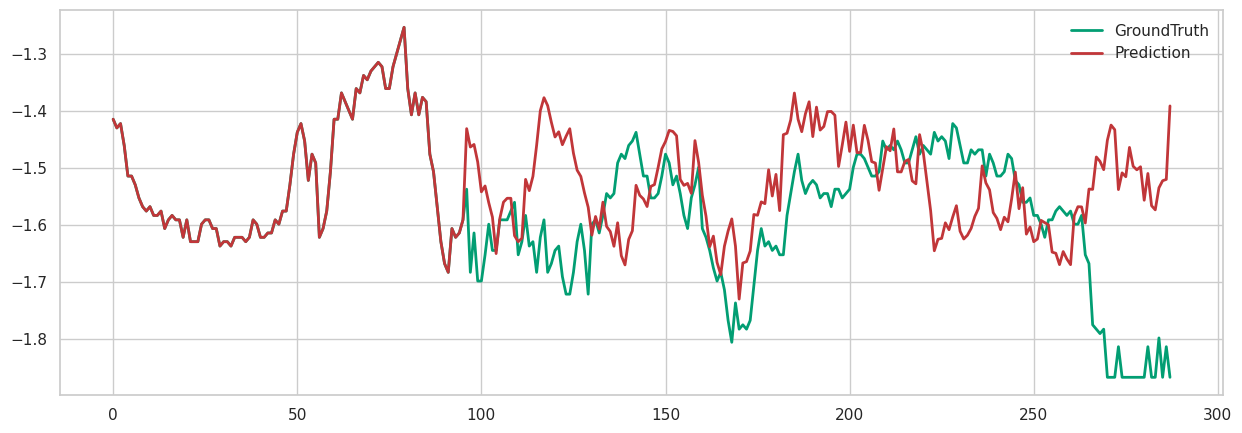

In [40]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTm1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [41]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [42]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11185
test 11185
	iters:  100, epoch: 1 | loss: 20.9179058
	speed: 0.4442sec/iter | left time: 2797.0323sec
	iters:  200, epoch: 1 | loss: 1.4736118
	speed: 0.4466sec/iter | left time: 2767.4392sec
	iters:  300, epoch: 1 | loss: 0.8335456
	speed: 0.4474sec/iter | left time: 2727.9489sec
	iters:  400, epoch: 1 | loss: 0.8844404
	speed: 0.4481sec/iter | left time: 2687.5122sec
	iters:  500, epoch: 1 | loss: 0.7842948
	speed: 0.4476sec/iter | left time: 2639.5614sec
	iters:  600, epoch: 1 | loss: 0.5654474
	speed: 0.4469sec/iter | left time: 2590.5678sec
	iters:  700, epoch: 1 | loss: 0.5952287
	speed: 0.4474sec/iter | left time: 2549.0111sec
	iters:  800, epoch: 1 | loss: 0.5985683
	speed: 0.4469sec/iter | left time: 2501.0464sec
	iters:  900, epoch: 1 | loss: 0.4606348
	speed: 0.4463sec/iter | left time: 2453.3580sec
	iters: 1000, epoch: 1 | loss: 0.5063095
	speed: 0.4463sec/iter | left time: 2408.5564sec
Epoch: 1 cost time: 476.5434215068817
Epoch: 1, St

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11185
test shape: (11168, 336, 7) (11168, 336, 7)
mae:0.5076478719711304, mse:0.5512290596961975, rmse:0.7424480319023132, mape:2.830765962600708, mspe:402.93011474609375


<Figure size 1500x500 with 0 Axes>

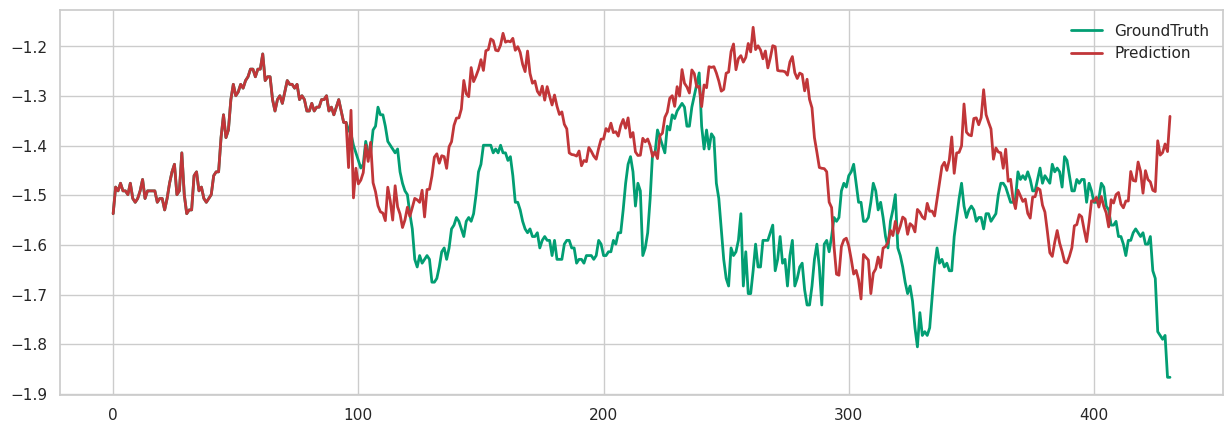

In [43]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTm1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [44]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [45]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters:  100, epoch: 1 | loss: 12.2097778
	speed: 0.7030sec/iter | left time: 4376.4366sec
	iters:  200, epoch: 1 | loss: 0.7576021
	speed: 0.7070sec/iter | left time: 4330.6233sec
	iters:  300, epoch: 1 | loss: 0.6243784
	speed: 0.7073sec/iter | left time: 4261.3241sec
	iters:  400, epoch: 1 | loss: 0.6709821
	speed: 0.7073sec/iter | left time: 4190.6596sec
	iters:  500, epoch: 1 | loss: 0.6408778
	speed: 0.7077sec/iter | left time: 4122.1198sec
	iters:  600, epoch: 1 | loss: 0.5934734
	speed: 0.7071sec/iter | left time: 4048.0202sec
	iters:  700, epoch: 1 | loss: 0.6953210
	speed: 0.7071sec/iter | left time: 3977.6159sec
	iters:  800, epoch: 1 | loss: 0.6732972
	speed: 0.7072sec/iter | left time: 3907.4806sec
	iters:  900, epoch: 1 | loss: 0.6029686
	speed: 0.7082sec/iter | left time: 3842.0446sec
	iters: 1000, epoch: 1 | loss: 0.6546381
	speed: 0.7077sec/iter | left time: 3768.6471sec
Epoch: 1 cost time: 745.7280449867249
Epoch: 1, St

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 10801
test shape: (10784, 720, 7) (10784, 720, 7)
mae:0.5082563161849976, mse:0.5443576574325562, rmse:0.737805962562561, mape:2.663907527923584, mspe:352.13543701171875


<Figure size 1500x500 with 0 Axes>

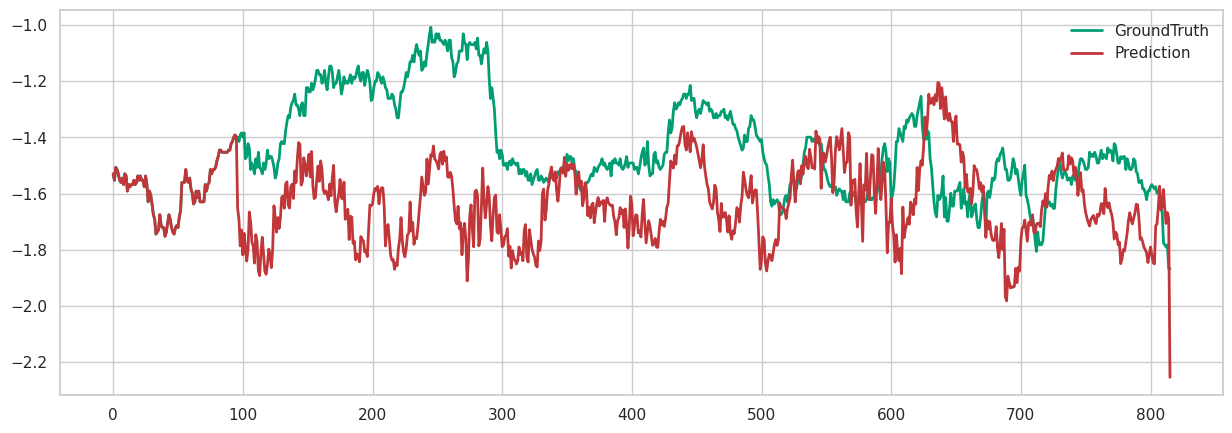

In [46]:
exp.test(setting)
torch.cuda.empty_cache()

---
# Working on ETTm2 Dataset
---

## Trail 1: FEDFormer, Dataset:ETTm2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [47]:
args.pred_len = 96
args.data = 'ETTm2'            # dataset name
args.data_path = 'ETTm2.csv'   # data file

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [48]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34369
val 11425
test 11425
	iters:  100, epoch: 1 | loss: 0.2357821
	speed: 0.2889sec/iter | left time: 1833.1973sec
	iters:  200, epoch: 1 | loss: 28.7933712
	speed: 0.2902sec/iter | left time: 1812.0192sec
	iters:  300, epoch: 1 | loss: 0.6721233
	speed: 0.2896sec/iter | left time: 1779.3767sec
	iters:  400, epoch: 1 | loss: 0.3272592
	speed: 0.2897sec/iter | left time: 1750.9687sec
	iters:  500, epoch: 1 | loss: 0.2069510
	speed: 0.2898sec/iter | left time: 1722.7407sec
	iters:  600, epoch: 1 | loss: 0.3547868
	speed: 0.2901sec/iter | left time: 1695.8018sec
	iters:  700, epoch: 1 | loss: 0.3704340
	speed: 0.2898sec/iter | left time: 1664.8475sec
	iters:  800, epoch: 1 | loss: 0.2472228
	speed: 0.2898sec/iter | left time: 1636.2023sec
	iters:  900, epoch: 1 | loss: 0.1477018
	speed: 0.2897sec/iter | left time: 1606.6153sec
	iters: 1000, epoch: 1 | loss: 0.1812004
	speed: 0.2908sec/iter | left time: 1583.4667sec
Epoch: 1 cost time: 311.5910859107971
Epoch: 1, St

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11425
test shape: (11424, 96, 7) (11424, 96, 7)
mae:0.31412816047668457, mse:0.2314925640821457, rmse:0.4811367392539978, mape:1.3085455894470215, mspe:270.5905456542969


<Figure size 1500x500 with 0 Axes>

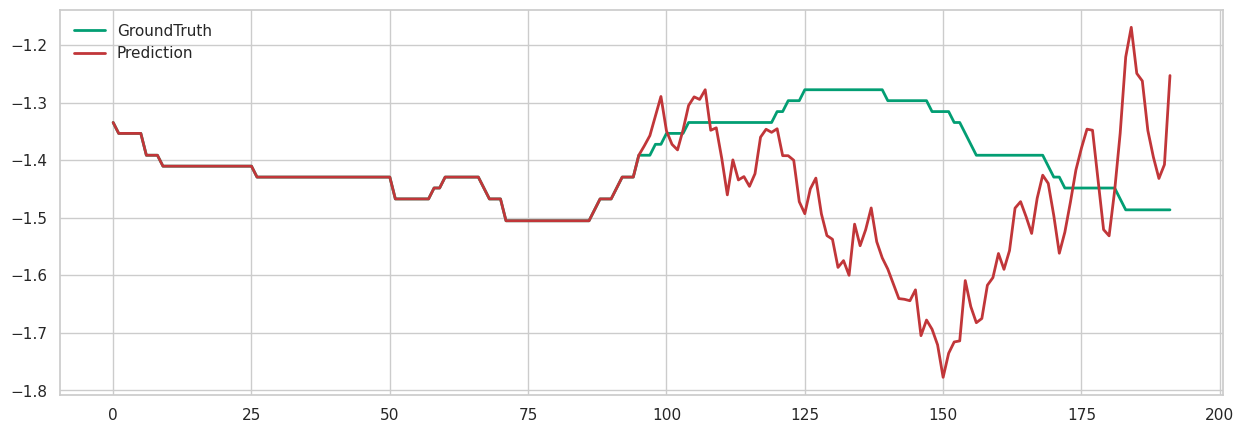

In [49]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTm2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [50]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [51]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34273
val 11329
test 11329
	iters:  100, epoch: 1 | loss: 0.3889633
	speed: 0.3486sec/iter | left time: 2205.7198sec
	iters:  200, epoch: 1 | loss: 479.1379700
	speed: 0.3511sec/iter | left time: 2186.2285sec
	iters:  300, epoch: 1 | loss: 5.2084990
	speed: 0.3510sec/iter | left time: 2150.2923sec
	iters:  400, epoch: 1 | loss: 7.5029893
	speed: 0.3509sec/iter | left time: 2115.1469sec
	iters:  500, epoch: 1 | loss: 3.3626542
	speed: 0.3515sec/iter | left time: 2083.0761sec
	iters:  600, epoch: 1 | loss: 2.6086729
	speed: 0.3513sec/iter | left time: 2047.1981sec
	iters:  700, epoch: 1 | loss: 2.0544419
	speed: 0.3511sec/iter | left time: 2010.8384sec
	iters:  800, epoch: 1 | loss: 3.1015153
	speed: 0.3507sec/iter | left time: 1973.4496sec
	iters:  900, epoch: 1 | loss: 2.3695838
	speed: 0.3512sec/iter | left time: 1941.1865sec
	iters: 1000, epoch: 1 | loss: 1.1835132
	speed: 0.3511sec/iter | left time: 1905.3890sec
Epoch: 1 cost time: 376.0473823547363
Epoch: 1, S

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11329
test shape: (11328, 192, 7) (11328, 192, 7)
mae:0.3774198293685913, mse:0.31279706954956055, rmse:0.559282660484314, mape:1.9187605381011963, mspe:494.4761047363281


<Figure size 1500x500 with 0 Axes>

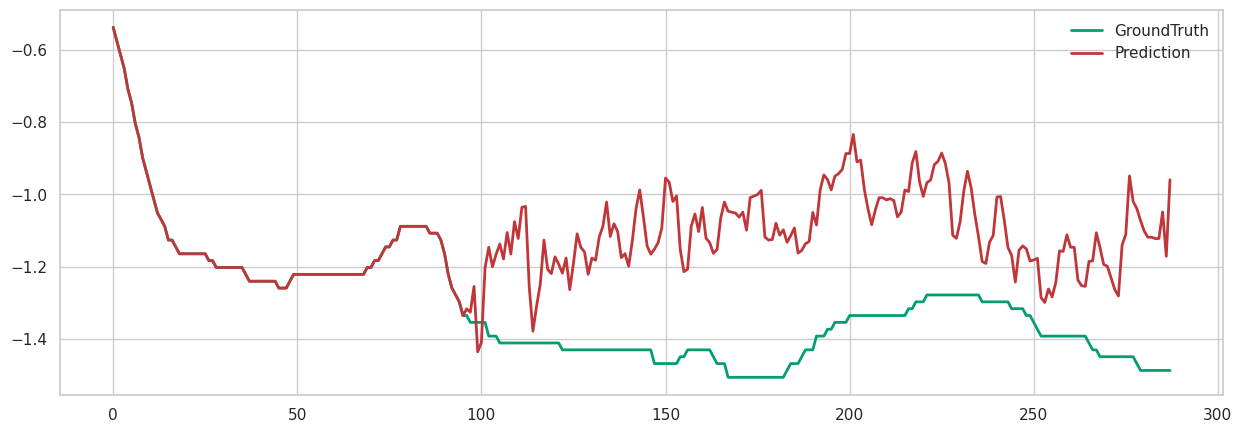

In [52]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTm2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [53]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [54]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11185
test 11185
	iters:  100, epoch: 1 | loss: 0.2986595
	speed: 0.4423sec/iter | left time: 2785.4616sec
	iters:  200, epoch: 1 | loss: 0.5059988
	speed: 0.4451sec/iter | left time: 2758.4357sec
	iters:  300, epoch: 1 | loss: 0.7792892
	speed: 0.4446sec/iter | left time: 2711.0056sec
	iters:  400, epoch: 1 | loss: 245.5748749
	speed: 0.4453sec/iter | left time: 2670.7391sec
	iters:  500, epoch: 1 | loss: 36.6369171
	speed: 0.4453sec/iter | left time: 2626.0825sec
	iters:  600, epoch: 1 | loss: 15.8848200
	speed: 0.4453sec/iter | left time: 2581.5767sec
	iters:  700, epoch: 1 | loss: 12.4325285
	speed: 0.4456sec/iter | left time: 2538.6485sec
	iters:  800, epoch: 1 | loss: 8.4449205
	speed: 0.4451sec/iter | left time: 2491.1300sec
	iters:  900, epoch: 1 | loss: 6.9487853
	speed: 0.4452sec/iter | left time: 2447.2445sec
	iters: 1000, epoch: 1 | loss: 5.1571574
	speed: 0.4454sec/iter | left time: 2403.7780sec
Epoch: 1 cost time: 474.6179184913635
Epoch: 1

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11185
test shape: (11168, 336, 7) (11168, 336, 7)
mae:0.45223239064216614, mse:0.42845234274864197, rmse:0.6545627117156982, mape:2.4289133548736572, mspe:829.0882568359375


<Figure size 1500x500 with 0 Axes>

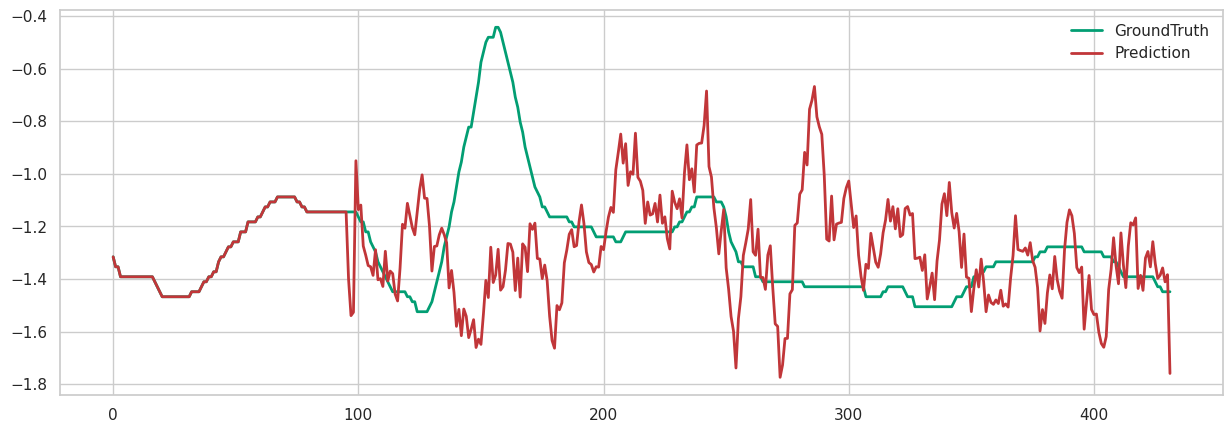

In [55]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTm2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [56]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'modes': 32, 'moving_avg': [12]}


### Training

In [57]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters:  100, epoch: 1 | loss: 0.2983071
	speed: 0.7022sec/iter | left time: 4371.1012sec
	iters:  200, epoch: 1 | loss: 0.5503935
	speed: 0.7074sec/iter | left time: 4332.9670sec
	iters:  300, epoch: 1 | loss: 0.9701112
	speed: 0.7078sec/iter | left time: 4264.7804sec
	iters:  400, epoch: 1 | loss: 0.4136286
	speed: 0.7076sec/iter | left time: 4192.4401sec
	iters:  500, epoch: 1 | loss: 2.6988754
	speed: 0.7072sec/iter | left time: 4119.2501sec
	iters:  600, epoch: 1 | loss: 117.4097519
	speed: 0.7073sec/iter | left time: 4049.2203sec
	iters:  700, epoch: 1 | loss: 10.9603739
	speed: 0.7074sec/iter | left time: 3979.2080sec
	iters:  800, epoch: 1 | loss: 6.3890157
	speed: 0.7081sec/iter | left time: 3912.0962sec
	iters:  900, epoch: 1 | loss: 5.1549053
	speed: 0.7079sec/iter | left time: 3840.0878sec
	iters: 1000, epoch: 1 | loss: 4.4679418
	speed: 0.7077sec/iter | left time: 3768.3951sec
Epoch: 1 cost time: 745.7582857608795
Epoch: 1, 

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 10801
test shape: (10784, 720, 7) (10784, 720, 7)
mae:0.4867933392524719, mse:0.500870943069458, rmse:0.7077223658561707, mape:2.2900118827819824, mspe:700.39794921875


<Figure size 1500x500 with 0 Axes>

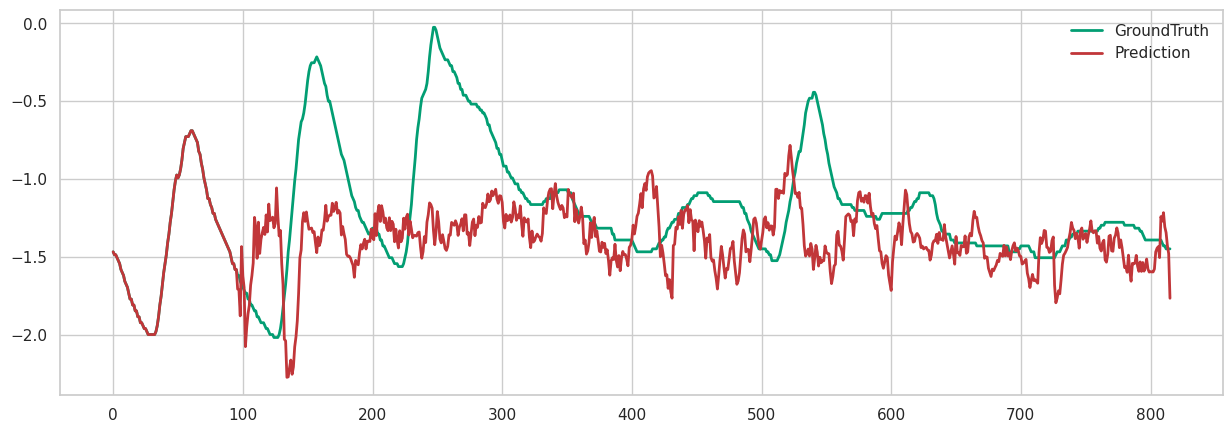

In [58]:
exp.test(setting)
torch.cuda.empty_cache()

In [1]:
!zip FEDformer_checkpoints.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/FEDFormer_checkpoints/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/FEDFormer_checkpoints/FEDformer_train_on_ETTh1_192/checkpoint.pth (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/FEDFormer_checkpoints/FEDformer_train_on_ETTh1_336/checkpoint.pth (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/FEDFormer_checkpoints/FEDformer_train_on_ETTh1_720/checkpoint.pth (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/FEDFormer_checkpoints/FEDformer_train_on_ETTh1_96/checkpoint.pth (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/FEDFormer_checkpoints/FEDformer_train_on_ETTh2_192/checkpoint.pth (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-

In [60]:
!zip FEDformer_test_results.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/FEDformer_train_on_ETTh1_192/last_batch.pdf (deflated 23%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/FEDformer_train_on_ETTh1_336/last_batch.pdf (deflated 20%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/FEDformer_train_on_ETTh1_720/last_batch.pdf (deflated 15%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/FEDformer_train_on_ETTh1_96/last_batch.pdf (deflated 26%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/FEDformer_train_on_ETTh2_192/last_batch.pdf (deflated 24%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/FEDformer_train_on_ETTh2_336/last_batch.pdf (deflated 21%)

In [61]:
!zip FEDformer_results.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/FEDformer_train_on_ETTh1_192/metrics.npy (deflated 40%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/FEDformer_train_on_ETTh1_192/pred.npy (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/FEDformer_train_on_ETTh1_192/true.npy (deflated 99%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/FEDformer_train_on_ETTh1_336/metrics.npy (deflated 40%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/FEDformer_train_on_ETTh1_336/pred.npy (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/FEDformer_train_on_ETTh1_336/true.npy (deflated 99%)
  adding: kaggle/working/Transformer-based-solutions-for-the